In [2]:
from files.utils.utility_functions import *
from files.pif.pif import *

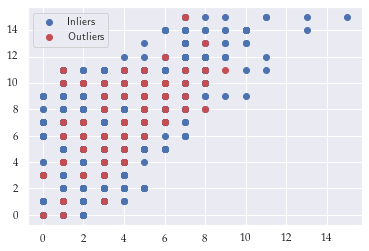

In [9]:
def read_csv(path):
    with open(path, "r") as f:
        content = f.read().split("\n")
    content = [list(map(lambda x: 1 if x=="\"n\"" else 0 if x=="\"o\"" else float(x), c.split(","))) for c in content]
    return np.array(content)



path = r"/home/catonz/Neural-PreferenceIsolation/datasets/letter-unsupervised-ad.csv"

dataset = read_csv(path)

gt = dataset[:,-1]

dataset = np.delete(dataset, -1, axis=1)

inliers = np.where(gt == 1)
outliers = np.where(gt == 0)

plt.scatter(dataset[:,0][inliers],  dataset[:,1][inliers], label="Inliers")
plt.scatter(dataset[:,0][outliers], dataset[:,1][outliers], c="r", label="Outliers")
plt.legend()

In [10]:
dataset.shape

(1600, 32)

In [13]:
5*np.sqrt(dataset.shape[0])

200.0

In [16]:
som = SelfOrganizingMaps(data=dataset, n_rows=14, n_cols=14, n_dimensions=dataset.shape[1], init_type=PCA, sigma=5, lr=2)
print(som.minisom.quantization_error(dataset))
som.fit(data=dataset, epochs=500)
print(som.minisom.quantization_error(dataset))

36.96522787221742
12.199124178308402


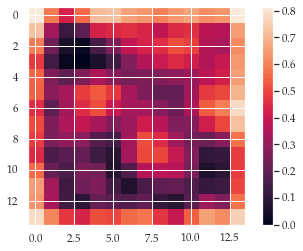

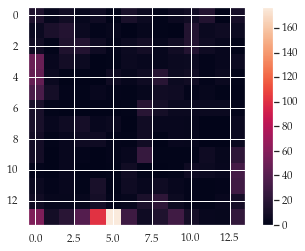

In [17]:
plt.imshow(1-som.minisom.distance_map())
plt.colorbar()

plt.figure()
plt.imshow(som.minisom.activation_response(dataset))
plt.colorbar()

In [22]:
residuals = som.get_residuals(dataset)

In [26]:
som_auc, *_ = make_roc(gt, residuals, show=False, to_plot=False);
print("SOM AUC: ", som_auc)

SOM AUC:  0.5306733333333333


In [5]:
len(np.where(gt == 1)[0]), len(np.where(gt == 0)[0])

(357, 10)

In [46]:
params = {
    "root_path": "/home/catonz/Neural-PreferenceIsolation",

    "mss": 50,
    "num_models": 1000,
    "training_epochs": 200,

    "AE_structure": {
        "neurons": [32, 16, 8, 16, 32],
        "activation": torch.relu
    },

    "SOM_structure": {
        "n_rows": 5,
        "n_cols": 5,
        "sigma": "default"
    }
}

pif = PreferenceIsolationForest(data=dataset, model_name=AE)
scores = pif.anomaly_detection(in_th=0.1, params=params)

pif_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

Anomaly Detection
--------------------------------------------------
Building RanSac models
Iteration 1000/1000: [==============================] (100%) ETA: 0:11:18.889788
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done
PIF AUC:  0.4612266666666667


In [44]:
from sklearn.ensemble import IsolationForest as iFor

ifor = iFor().fit(dataset)
scores_ifor = -ifor.score_samples(dataset)
ifor_auc, *_ = make_roc(gt, scores_ifor, show=False, to_plot=False);
print("iFor AUC: ", ifor_auc)

iFor AUC:  0.63464


In [38]:
from files.classes.neural_models import *

nen = NeuralNetwork(neurons=[dataset.shape[1], 20, 13, 7, 13, 20, dataset.shape[1]], activation=torch.tanh)
nen.fit(epochs=500, data=dataset, print_training=True, bs=32)
scores = nen.get_residuals(dataset)

Epoch 500/500: [==============================] (100%) ETA: 0:00:34.771843 Mean Loss: 5.00822


In [39]:
pif_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

PIF AUC:  0.6659599999999999


In [ ]:
dims = [25,29]
preds = nen.predict(dataset)
plot(dataset[:,dims], c=~gt.astype(bool))
plot(preds[:,dims], c="r")

In [ ]:
x = torch.FloatTensor(dataset.copy())
for l in nen.layers[:3]:
    x = torch.relu(l(x))
preds = x.detach().numpy()

plot(preds)

In [ ]:
path = r"/home/catonz/Neural-PreferenceIsolation/datasets/shuttle-unsupervised-ad.csv"

dataset2 = read_csv(path)

gt2 = dataset2[:,-1]

dataset2 = np.delete(dataset2, -1, axis=1)

inliers = np.where(gt2 == 1)
outliers = np.where(gt2 == 0)

x_dim = 4
y_dim = 5

plt.scatter(dataset2[:,x_dim][inliers],  dataset2[:,y_dim][inliers], label="Inliers")
plt.scatter(dataset2[:,x_dim][outliers], dataset2[:,y_dim][outliers], c="r", label="Outliers")
plt.legend()

In [ ]:
params = {
    "root_path": "/home/catonz/Neural-PreferenceIsolation",

    "mss": 10,
    "num_models": 100,
    "training_epochs": 200,

    "models_to_use": ["ae"],

    "AE_structure": {
        "neurons": [9, 2, 9],
        "activation": torch.relu
    },
}

pif = PreferenceIsolationForest(data=dataset, model_name=AE)
scores = pif.anomaly_detection(params=params)

In [ ]:
pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

In [ ]:
from sklearn.ensemble import IsolationForest as iFor

ifor = iFor().fit(dataset2)
scores_ifor = -ifor.score_samples(dataset2)
ifor_auc, *_ = make_roc(gt2, scores_ifor, show=False, to_plot=False);
print("iFor AUC: ", ifor_auc)

In [ ]:
nen = NeuralNetwork(neurons=[9, 2, 9], activation=torch.relu)
nen.fit(epochs=50, data=dataset2[np.random.randint(0, len(dataset2), params["mss"])], print_training=True, bs=2)
scores = nen.get_residuals(dataset2)
pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

In [ ]:
for nen in pif.models:
#     nen = pif.models[1]
    scores = nen.get_residuals(dataset2)
    pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
    print("PIF AUC: ", pif_auc)

In [ ]:
x = torch.FloatTensor(dataset.copy())
for l in nen.layers[:3]:
    x = torch.relu(l(x))
preds = x.detach().numpy()

plot(preds[inliers])
plt.figure()
plot(preds[outliers])

In [2]:
from files.utils.utility_functions import *

In [5]:
x = np.random.uniform(-2.5, 2.5, size=(500))
y = np.sin(x)
y_n = y + np.random.normal(0, 0.1, size=(len(x)))

outliers_x = np.random.uniform(x.min(), x.max(), size=(len(x)))
outliers_y = np.random.uniform(y_n.min(), y_n.max(), size=(len(x)))
outliers = np.dstack((outliers_x, outliers_y))[0]

ds = np.dstack((x, y_n))[0]
ds = np.vstack((ds, outliers))
ds.shape

(1000, 2)

In [7]:
from files.pif.pif import *

params = {
    "mss": 10,
    "num_models": 1000,
    "training_epochs": 500,

    "models_to_use": ["som"],

    "SOM_structure": {
        "n_rows": 5,
        "n_cols": 5,
        "sigma": "default"
    }
}

pif = PreferenceIsolationForest(data=ds, model_name=SOM)
scores = pif.anomaly_detection(in_th=0.1, params=params)

Anomaly Detection
--------------------------------------------------
Building RanSac models
Iteration 1000/1000: [==============================] (100%) ETA: 0:00:22.221757
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done
